# Evaluation of automatic annotations
This notebook demonstrates automatic annotation model evaluation.

First, load the required libraries.

In [1]:
import json

from matplotlib import pyplot as plt
from matplotlib import mlab
import numpy as np
from scipy.stats import gaussian_kde

Next, load the validation data

In [2]:
validation_file = "data/validation.test.json"
validation_file_all = "data/validation.all.json"
validation_file_train = "data/validation.train.json"
    
with open(validation_file, "r") as f:
    validation = json.load(f)
    
with open(validation_file_all, "r") as f:
    validation_all = json.load(f)
    
with open(validation_file_train, "r") as f:
    validation_train = json.load(f)
    
list(validation.keys())

['ious',
 'polyline_hausdorff_distances',
 'length_differences',
 'true_positives',
 'false_positives',
 'false_negatives']

Plot the Scores vs. Intersection over Union Density. A good model will show a peak in the top-right corner, have a high mean IoU, and show similar results for the full set and the test set.

mean IoU:
Full set: 0.81350781788987
Test set: 0.8054464736363467


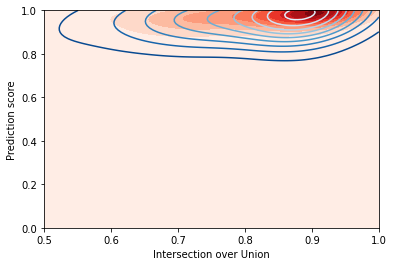

In [3]:
fig = plt.figure()

ax = fig.add_subplot(
    111,
    xlabel="Intersection over Union",
    ylabel="Prediction score",
)

iou_X, iou_Y = np.mgrid[0.5:1.:100j, 0.:1.:100j]
iou_positions = np.vstack([iou_X.ravel(), iou_Y.ravel()])

# All images
ious_all, iou_scores_all = zip(*validation_all["ious"])
ious_all = np.array(ious_all)
iou_scores_all = np.array(iou_scores_all)

iou_kernel_all = gaussian_kde(np.vstack([ious_all, iou_scores_all]))
iou_values_all = np.reshape(iou_kernel_all(iou_positions).T, iou_X.shape)

p = ax.contourf(
    iou_X,
    iou_Y,
    iou_values_all,
    levels=10,
    cmap="Reds",
)

# Test set
ious, iou_scores = zip(*validation["ious"])
ious = np.array(ious)
iou_scores = np.array(iou_scores)

iou_kernel = gaussian_kde(np.vstack([ious, iou_scores]))
iou_values = np.reshape(iou_kernel(iou_positions).T, iou_X.shape)

p = ax.contour(
    iou_X,
    iou_Y,
    iou_values,
    levels=10,
    cmap="Blues_r",
)

print("mean IoU:")
print(f"Full set: {np.mean(ious_all)}")
print(f"Test set: {np.mean(ious)}")

In [4]:
p.levels

array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ])

Plot the Scores vs. Hausdorff Distance Density. A good model will show a peak in the top-left corner, have a low mean Hausdorff Distance, and show similar results for the full set and the test set.

mean Hausdorff distance:
Full set: 29.22432010629675
Test set: 28.7661875431487


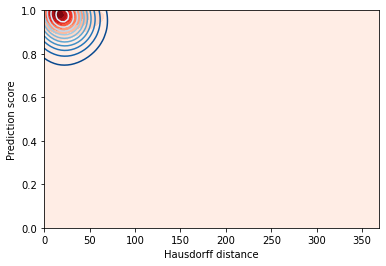

In [5]:
fig = plt.figure()

ax = fig.add_subplot(
    111,
    xlabel="Hausdorff distance",
    ylabel="Prediction score",
)

# All images
phds_all, phd_scores_all = zip(*validation_all["polyline_hausdorff_distances"])
phds_all = np.array(phds_all)
phd_scores_all = np.array(phd_scores_all)

# Test set
phds, phd_scores = zip(*validation["polyline_hausdorff_distances"])
phds = np.array(phds)
phd_scores = np.array(phd_scores)

max_phd = max(phds_all.max(), phds.max())

phd_X, phd_Y = np.mgrid[0.:max_phd:100j, 0.:1.:100j]
phd_positions = np.vstack([phd_X.ravel(), phd_Y.ravel()])

# All images
phd_kernel_all = gaussian_kde(np.vstack([phds_all, phd_scores_all]))
phd_values_all = np.reshape(phd_kernel_all(phd_positions).T, phd_X.shape)

p = ax.contourf(
    phd_X,
    phd_Y,
    phd_values_all,
    levels=10,
    cmap="Reds",
)

# Test set
phd_kernel = gaussian_kde(np.vstack([phds, phd_scores]))
phd_values = np.reshape(phd_kernel(phd_positions).T, phd_X.shape)

p = ax.contour(
    phd_X,
    phd_Y,
    phd_values,
    levels=10,
    cmap="Blues_r",
)

print("mean Hausdorff distance:")
print(f"Full set: {np.mean(phds_all)}")
print(f"Test set: {np.mean(phds)}")

Plot the Scores vs. Length Difference Density. A good model will show a peak in the top-centre, have a low mean and standard deviation of length difference, and show similar results for the full set and the test set.

mean length difference:
Full set: -3.3113490097979486
Test set: 5.139907360076904
mean absolute length difference:
Full set: 28.527202411066206
Test set: 28.535170078277588
std length difference:
Full set: 46.45187528432884
Test set: 51.019546538599364


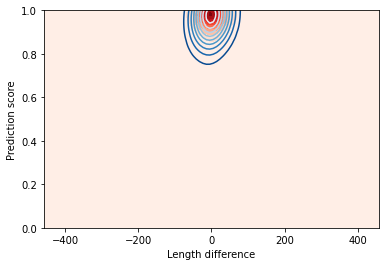

In [6]:
fig = plt.figure()

ax = fig.add_subplot(
    111,
    xlabel="Length difference",
    ylabel="Prediction score",
)

# All images
l_diffs_all, l_diff_scores_all = zip(*validation_all["length_differences"])
l_diffs_all = np.array(l_diffs_all)
l_diff_scores_all = np.array(l_diff_scores_all)

# Test set
l_diffs, l_diff_scores = zip(*validation["length_differences"])
l_diffs = np.array(l_diffs)
l_diff_scores = np.array(l_diff_scores)

max_l_diff = max(np.abs(l_diffs_all).max(), np.abs(l_diffs).max())

l_diff_X, l_diff_Y = np.mgrid[-max_l_diff:max_l_diff:100j, 0.:1.:100j]
l_diff_positions = np.vstack([l_diff_X.ravel(), l_diff_Y.ravel()])

# All images
l_diff_kernel_all = gaussian_kde(np.vstack([l_diffs_all, l_diff_scores_all]))
l_diff_values_all = np.reshape(l_diff_kernel_all(l_diff_positions).T, l_diff_X.shape)

p = ax.contourf(
    l_diff_X,
    l_diff_Y,
    l_diff_values_all,
    levels=10,
    cmap="Reds",
)

# Test set
l_diff_kernel = gaussian_kde(np.vstack([l_diffs, l_diff_scores]))
l_diff_values = np.reshape(l_diff_kernel(l_diff_positions).T, l_diff_X.shape)

p = ax.contour(
    l_diff_X,
    l_diff_Y,
    l_diff_values,
    levels=10,
    cmap="Blues_r",
)

print("mean length difference:")
print(f"Full set: {np.mean(l_diffs_all)}")
print(f"Test set: {np.mean(l_diffs)}")

print("mean absolute length difference:")
print(f"Full set: {np.mean(np.abs(l_diffs_all))}")
print(f"Test set: {np.mean(np.abs(l_diffs))}")

print("std length difference:")
print(f"Full set: {np.std(l_diffs_all)}")
print(f"Test set: {np.std(l_diffs)}")

Plot the score histograms for true positives and false positives. A good model will have a peak in true positives close to 1 and lower scores for false positives.

Full set:
True positives:   997
False positives: 12526
False negatives:  422

Test set:
True positives:    64
False positives:  106
False negatives:   25


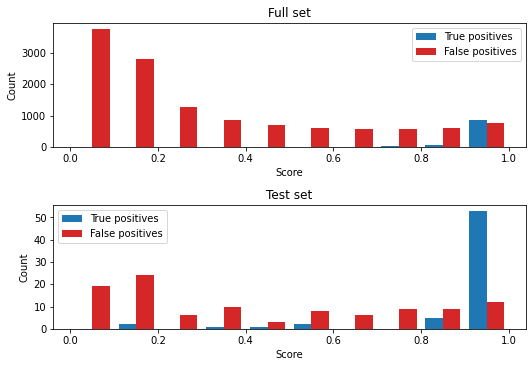

In [7]:
fig = plt.figure(
    figsize=(7.5, 5.2),
    tight_layout=True,
)
ax = fig.add_subplot(
    211,
    xlabel="Score",
    ylabel="Count",
    title="Full set",
)


h, b, p = ax.hist(
    [validation_all["true_positives"], validation_all["false_positives"]],
    bins=np.linspace(0., 1., num=11),
    label=["True positives", "False positives"],
    color=["tab:blue", "tab:red"],
)
ax.legend()

ax = fig.add_subplot(
    212,
    xlabel="Score",
    ylabel="Count",
    title="Test set",
)


h, b, p = ax.hist(
    [validation["true_positives"], validation["false_positives"]],
    bins=np.linspace(0., 1., num=11),
    label=["True positives", "False positives"],
    color=["tab:blue", "tab:red"],
)
ax.legend()

print("Full set:")
print(f'True positives:  {len(validation_all["true_positives"]):4d}')
print(f'False positives: {len(validation_all["false_positives"]):4d}')
print(f'False negatives: {validation_all["false_negatives"]:4d}')

print("\nTest set:")
print(f'True positives:  {len(validation["true_positives"]):4d}')
print(f'False positives: {len(validation["false_positives"]):4d}')
print(f'False negatives: {validation["false_negatives"]:4d}')

Plot Precision vs. Recall and calculate average precision for the full set, and the test set

AP_50:
Full set: 0.5879404115127285
Test set: 0.6866600298656048
Training set: 0.6683919288386905


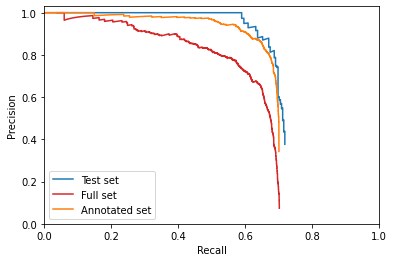

In [8]:
# Full set
true_positives_all = np.array(validation_all["true_positives"])
false_positives_all = np.array(validation_all["false_positives"])
false_negatives_all = validation_all["false_negatives"]

precision_all = [0.]
recall_all = [1.]

for score_cutoff in np.sort(np.concatenate((true_positives_all, false_positives_all))):
    tp = np.count_nonzero(true_positives_all >= score_cutoff)
    fp = np.count_nonzero(false_positives_all >= score_cutoff)
    try:
        pr = tp / (tp + fp)
        re = tp / (tp + false_negatives_all)
    except ZeroDivisionError:
        pass
    finally:
        precision_all.append(pr)
        recall_all.append(re)
        
precision_all.append(1.)
recall_all.append(0.)
        
precision_all = np.array(precision_all)
recall_all = np.array(recall_all)

ap_precision_values_all = []
for ap_recall_value in np.linspace(0., 1., num=11, endpoint=True):
    ap_precision_values_all.append(precision_all[recall_all >= ap_recall_value].max())

average_precision_all = sum(ap_precision_values_all) / len(ap_precision_values_all)

# Test set
true_positives = np.array(validation["true_positives"])
false_positives = np.array(validation["false_positives"])
false_negatives = validation["false_negatives"]

precision = [0.]
recall = [1.]

for score_cutoff in np.sort(np.concatenate((true_positives, false_positives))):
    tp = np.count_nonzero(true_positives >= score_cutoff)
    fp = np.count_nonzero(false_positives >= score_cutoff)
    try:
        pr = tp / (tp + fp)
        re = tp / (tp + false_negatives)
    except ZeroDivisionError:
        pass
    finally:
        precision.append(pr)
        recall.append(re)
        
precision.append(1.)
recall.append(0.)
        
precision = np.array(precision)
recall = np.array(recall)

ap_precision_values = []
for ap_recall_value in np.linspace(0., 1., num=11, endpoint=True):
    ap_precision_values.append(precision[recall >= ap_recall_value].max())

average_precision = sum(ap_precision_values) / len(ap_precision_values)

# Annotated only
true_positives_train = np.array(validation_train["true_positives"])
false_positives_train = np.array(validation_train["false_positives"])
false_negatives_train = validation_train["false_negatives"]

precision_train = [0.]
recall_train = [1.]

for score_cutoff in np.sort(np.concatenate((true_positives_train, false_positives_train))):
    tp = np.count_nonzero(true_positives_train >= score_cutoff)
    fp = np.count_nonzero(false_positives_train >= score_cutoff)
    try:
        pr = tp / (tp + fp)
        re = tp / (tp + false_negatives_train)
    except ZeroDivisionError:
        pass
    finally:
        precision_train.append(pr)
        recall_train.append(re)
        
precision_train.append(1.)
recall_train.append(0.)
        
precision_train = np.array(precision_train)
recall_train = np.array(recall_train)

ap_precision_values_train = []
for ap_recall_value in np.linspace(0., 1., num=11, endpoint=True):
    ap_precision_values_train.append(precision_train[recall_train >= ap_recall_value].max())

average_precision_train = sum(ap_precision_values_train) / len(ap_precision_values_train)
   
fig = plt.figure()
ax = fig.add_subplot(
    111,
    xlabel="Recall",
    ylabel="Precision",
    xlim=(0., 1.),
    ylim=(0., 1.03),
)
ax.plot(recall[1:-1], precision[1:-1], c="tab:blue", label="Test set")
ax.plot(recall_all[1:-1], precision_all[1:-1], c="tab:red", label="Full set")
ax.plot(recall_train[1:-1], precision_train[1:-1], c="tab:orange", label="Annotated set")
ax.legend()

print("AP_50:")
print(f"Full set: {average_precision_all}")
print(f"Test set: {average_precision}")
print(f"Training set: {average_precision_train}")

Putting together one figure

In [9]:
def get_quantiles(values):
    """
    converts values to quantiles
    
    Parameters
    ----------
    
    values: array
        evenly spaced kde estimate values
        
    Returns
    -------
    
    quantiles: array of shape values.shape
        can be passed to plt.contour to produce quantile contour plot
        
    to_value: callable
        takes a quantile as an argument and converts to value
    """
    sort_indices = np.unravel_index(np.argsort(values, axis=None), values.shape)
    sorted_values = values[sort_indices]
    integral = np.cumsum(sorted_values) / sorted_values.sum()
    
    quantiles = np.empty_like(values)
    quantiles[sort_indices] = integral
    
    def to_value(quant):
        return sorted_values[np.nonzero(integral >= quant)[0][0]]
        
    return quantiles, to_value

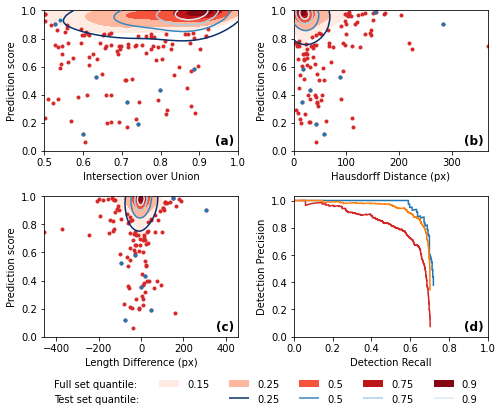

In [10]:
fontdict={"fontweight": "bold"}
tloc = "right"
ty = 0
cmap_all = "Reds"
cmap = "Blues_r"
c_all = "tab:red"
c = "tab:blue"
quantiles = np.array([0.25, 0.5, 0.75, 0.9, 1.])
quantiles_all = np.array([0.15, 0.25, 0.5, 0.75, 0.9, 1.])

iou_xlabel = "Intersection over Union"
phd_xlabel = "Hausdorff Distance (px)"
l_diff_xlabel = "Length Difference (px)"

iou_title = "(a) "
phd_title = "(b) "
l_diff_title = "(c) "
pr_title = "(d) "

fig_width = 180  # mm
fig_width /= 25.4  # inches
fig_height = fig_width * 3 / 4

fig = plt.figure(
    figsize=(fig_width, fig_height),
    tight_layout=True,
)

ax_loc = 220
for metric in ["iou", "phd", "l_diff"]:
    ax_loc += 1
    xlabel = locals()[f"{metric}_xlabel"]
    X = locals()[f"{metric}_X"]
    Y = locals()[f"{metric}_Y"]
    values_all = locals()[f"{metric}_values_all"]
    values = locals()[f"{metric}_values"]
    s_all = locals()[f"{metric}s_all"]
    s = locals()[f"{metric}s"]
    kernel_all = locals()[f"{metric}_kernel_all"]
    kernel = locals()[f"{metric}_kernel"]
    scores_all = locals()[f"{metric}_scores_all"]
    scores = locals()[f"{metric}_scores"]
    title = locals()[f"{metric}_title"]

    ax = fig.add_subplot(
        ax_loc,
        xlabel=xlabel,
        ylabel="Prediction score",
    )

    quantile_values, to_value = get_quantiles(values_all)
    p_all = ax.contourf(
        X,
        Y,
        quantile_values,
        levels=quantiles_all,
        cmap=cmap_all,
    )
    p_all_outlier_mask = kernel_all(np.vstack([s_all, scores_all])) < to_value(p_all.levels[0])
    o_all = ax.plot(
        s_all[p_all_outlier_mask],
        scores_all[p_all_outlier_mask],
        marker=".",
        ls="",
        c=c_all,
    )
    quantile_values, to_value = get_quantiles(values)
    p = ax.contour(
        X,
        Y,
        quantile_values,
        levels=quantiles,
        cmap=cmap,
        zorder=10,
    )
    p_outlier_mask = kernel(np.vstack([s, scores])) < to_value(p.levels[0])
    o = ax.plot(
        s[p_outlier_mask],
        scores[p_outlier_mask],
        marker=".",
        ls="",
        c=c,
    )
    t = ax.set_title(
        title,
        fontdict=fontdict,
        loc=tloc,
        y=ty,
    )

# Precision vs. Recall
ax4 = fig.add_subplot(
    224,
    xlabel="Detection Recall",
    ylabel="Detection Precision",
    xlim=(0., 1.),
    ylim=(0., 1.03),
)
ax4.plot(
    recall_all[1:-1],
    precision_all[1:-1],
    c=c_all,
    label="Full set",
)
ax4.plot(
    recall[1:-1],
    precision[1:-1],
    c=c,
    label="Test set",
)
ax4.plot(
    recall_train[1:-1], 
    precision_train[1:-1],
    c="tab:orange",
    label="Annotated set",
)
t4 = ax4.set_title(
    pr_title,
    fontdict=fontdict,
    loc=tloc,
    y=ty,
)

# Hacking together the contours figure legend
proxy = [plt.Rectangle((0, 0), 1, 1, fc=pc.get_facecolor()[0]) for pc in p_all.collections]
proxy = list(np.insert(proxy, range(2, len(p.collections) + 1), p.collections[:-1]))
labels = list(np.insert(quantiles_all[:-1], range(2, len(quantiles) + 1), quantiles[:-1]))
proxy.insert(1, plt.Rectangle((0, 0), 1, 1, fc="None")),
labels.insert(1, "")

proxy1 = [plt.Rectangle((0, 0), 1, 1, fc="None"), plt.Rectangle((0, 0), 1, 1, fc="None")]
#proxy1 = ["None", "None"]
labels1 = ["Full set quantile:", "Test set quantile:"]

proxy1.extend(proxy)
labels1.extend(labels)

leg = fig.legend(
    proxy1,
    labels1,
    loc="lower center",
    #title="Contour Quantile",
    ncol=len(quantiles_all),
    bbox_to_anchor=(0.5, -0.09),
    frameon=False,
    #markerfirst=False,
)

In [11]:
fig.savefig("autoannotation_evaluation_figure.pdf", dpi=600.0, bbox_inches="tight")